# Imports

In [10]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import time
%matplotlib inline
set_seed = torch.manual_seed(0)

# Data generator

In [11]:
def regression_data_generator(n, k=1):
    '''
    n is the number of samples per minibatch
    k is the dimensionality of each vector x
    '''
    x = torch.rand(n, k) #x is nxk
    w = torch.tensor([10.0])       #parameter initialization

    y = torch.tensor([torch.dot(w, v_i) for v_i in x])

    return x, y

# Model


In [12]:
class Regression_model:
    def __init__(self, k = 2, sigma = 0.01):
        self.W = torch.normal(mean=0,
                              std=sigma,
                              size=(k,),
                              requires_grad=True)
        self.b = torch.zeros(size=(1,), requires_grad=True)
        
    def forward(self, x):
        return x@(self.W.reshape((x.shape[-1], 1))) + self.b

# Loss

In [13]:
def l2_loss(y, y_hat):
    '''
    Remember that y (true value) and y_hat (prediction) are nxk
    '''
    
    l = (y_hat-torch.reshape(y, y_hat.shape)) ** 2 / 2
    return l.mean()

# Optimizer

In [14]:
class SGD:
    def __init__(self, parameters, lr = 0.01):
        self.lr = lr
        self.parameters = parameters

    def step(self):
        for p in self.parameters:
            p -= self.lr * p.grad

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

# Trainer

In [15]:
class Trainer:
    def __init__(self, model, loss, optimizer, iterations = 20, epochs = 5):
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.iterations = iterations
        self.epochs = epochs

    def live_plot(self, x, y, figsize=(7,5), title=''):
        '''
        It plots only the average loss per epoch.
        '''
        clear_output(wait=True)         # This is needed for live updates
        plt.figure(figsize=figsize)
        x = [float(i) for i in x]
        y = [float(i) for i in y]
        
        if len(x) > 1:
            plt.scatter(x,y, label='axis y', color='k') 

        plt.title(title)
        plt.grid(True)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.show()
        
    def fit_model(self, data_generator):
        '''
        A function that creates the training data,
        optimizes the model and plots the results.
        '''
        x, y = data_generator(self.iterations)
        train_loss = np.array([])

        for i in range(self.epochs):
            y_hat = self.model.forward(x)
            loss = self.loss(y, y_hat)
            train_loss = np.append(train_loss, loss.item())   # this is needed for plotting

            self.optimizer.zero_grad()
            with torch.no_grad():
                loss.backward()
                self.optimizer.step()

            # Updating the training plot
            self.live_plot(np.arange(i+1), train_loss, title="Training loss")        

# Training tests


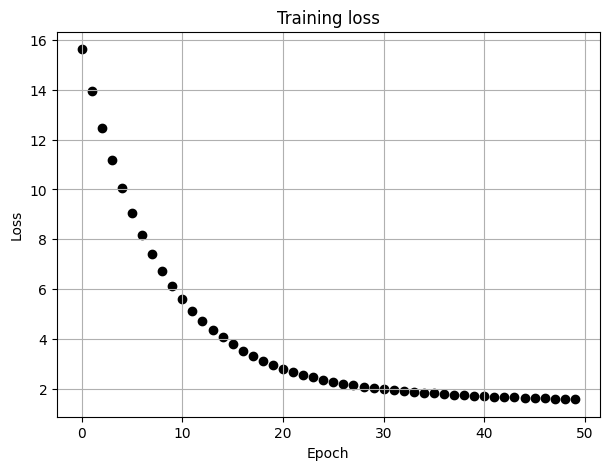

In [16]:
model = Regression_model(k=1)
optimizer = SGD([model.W, model.b], lr=0.05)
trainer = Trainer(model, l2_loss, optimizer, epochs=50)

trainer.fit_model(regression_data_generator)

# Real line vs Fitted line

/home/pachy/.cache/pypoetry/virtualenvs/dlcourse-BfLxQsIA-py3.11/lib/python3.11/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


ValueError: could not broadcast input array from shape (50,1) into shape (50,)

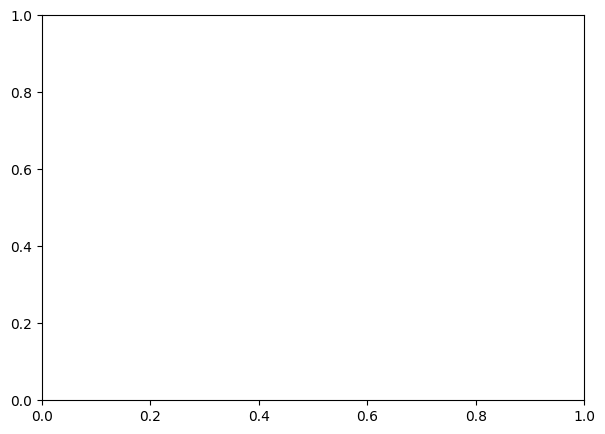

In [20]:
x, y = regression_data_generator(50)
y_hat = model.forward(x)

plt.figure(figsize=(7, 5))

plt.scatter(x.detach().numpy(),[y.detach().numpy(), y_hat.detach().numpy()],
            label='axis y', color='k') 

plt.title("Real vs fitted line")
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()